# Implementing Autograd

In this notebook we will understand and implement how Pytorch and other libraries compute gradient and performing backpropagation.

## Calculate Gradients

In [198]:
import math
import numpy as np
import matplotlib.pyplot as plt

Creating $f(x) = 3x^{2} - 4x + 5$, which has derivative of $f'(x) = 6x - 4$

In [173]:
def f(x):
    return 3*x**2 - 4*x + 5

Plotting the Function

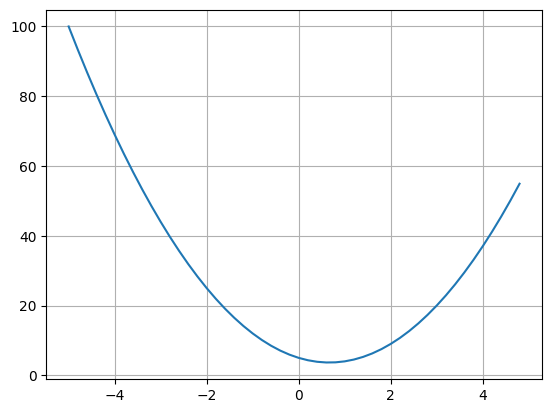

In [174]:
x = np.arange(-5, 5, 0.2) # does not include 5
plt.plot(x, f(x))
plt.grid()
plt.show()

We can calculate the derivative of some point $x$ using the definition: $f'(x) = \lim_{h \rightarrow 0} \cfrac{f(x + h) - f(x)}{h}$

In [175]:
# Setting `h` a very small number
h = 1e-5
x = 3

print((f(x + h) - f(x)) / h)

14.00003000000538


where $f'(3) = 14$

In [176]:
x = -3

print((f(x + h) - f(x)) / h)

-21.999970000052823


where $f'(-3) = -22$

In [177]:
x = 2/3

print((f(x + h) - f(x)) / h)

3.0000002482211127e-05


where $f'(2/3) = 0$

Plotting the Derivative of $f$

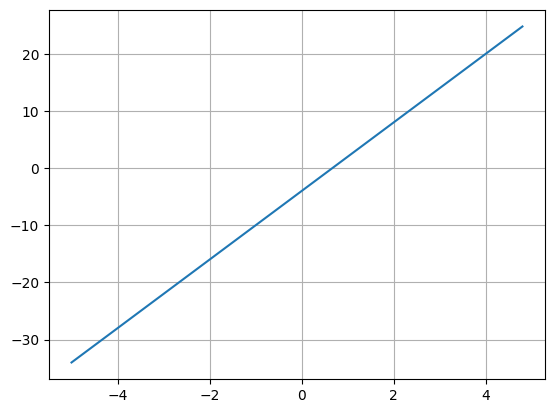

In [178]:
x = np.arange(-5, 5, 0.2)
plt.plot(x, (f(x + h) - f(x))/h)
plt.grid()
plt.show()

Let's add more complexity to the function

In [179]:
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
print(d1)

4.0


In [180]:
a = 2.0
b = -3.0
c = 10.0

a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)

print((d2 - d1)/ h)

d1 4.0
d2 3.9999699999999994
-3.000000000064062


where $\cfrac{d}{da}{d_1} = b = -3$

In [181]:
a = 2.0
b = -3.0
c = 10.0

b += h
d3 = a*b + c

print("d1", d1)
print("d3", d3)

print((d3 - d1)/ h)

d1 4.0
d3 4.00002
2.0000000000131024


where $\cfrac{d}{db}{d_1} = a = 2$

In [182]:
a = 2.0
b = -3.0
c = 10.0

c += h
d4 = a*b + c

print("d1", d1)
print("d4", d4)

print((d4 - d1)/ h)

d1 4.0
d4 4.00001
0.9999999999621422


where $\cfrac{d}{dc}{d_1} = 1$

## Creating a Class that Captures the gradient relationships between numbers

Becuase the gradient expression of neural networks are massive, we need a data structure (a class) to maintain those expressions.

We need a way to tell us what values are producing what values (eg. a,b and c produce d in the example above).

In [199]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        `_children` (tuple): For a `Value` object tell us the `Value` objects that produce it.
        `_op` (str): The operation that from children we can produce `self`.
        `label` (str): The label of the object, for visualizing the expression.
        """

        self.data = data
        self.grad = 0.0             # Initializing to 0 because we don't want to affect the output
        self._prev = set(_children) # We are storing in a set for efficiency, O(logn) retrieving and adding complexity
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value=({self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, _children=(self, other), _op='+')

    def __mul__(self, other):
        return Value(self.data * other.data, _children=(self, other), _op='*')
    
    def tanh(self):
        return Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), _children=(self,), _op="tanh")

In [184]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

d1 = a*b + c

print(d1)
print(d1._prev)
print(d1._op)

Value=(4.0)
{Value=(-6.0), Value=(10.0)}
+


In [185]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b ; e.label = 'e'
d = e + c ; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f ; L.label = 'L'

print(L)

Value=(-8.0)


where  $Value=(-6.0)$  is the result of  $a \cdot b$  and  $Value=(10.0)$  is $c$.

## Creating a Function to Visualize Values

In [186]:
from graphviz import Digraph

This function creates the Graph of `Value` object, which we will visualize.

In [187]:
def trace(root):
    # Building a set of all nodes and edges in the graph
    nodes, edges = set(), set()

    # Adding recursivly the previous `Values`` of v
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

This function visualize the Graph.

In [188]:
def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR: left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n)) # the specifier/name of each node (in memory)

        # Creating a recragular `record` for every node of the graph
        if n.label:
            dot.node(name=uid, label="{%s | d:%.4f | g:%.4f}" % (n.label, n.data, n.grad), shape="record")
        else:
            dot.node(name=uid, label="{d:%.4f | g:%.4f}" % (n.data, n.grad), shape="record")

        # Creating a node for the operation if this node is produced by one
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid) # connect the 2 nodes: (uid + n._op) --> (uid)

    # Connecting the `other` Value to the operator of `self`
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

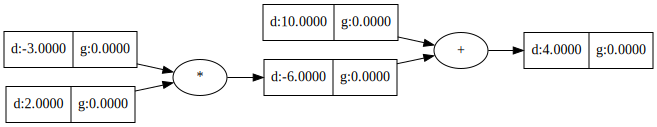

In [189]:
draw_dot(d1)

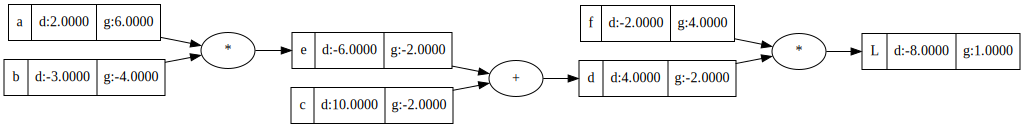

In [197]:
draw_dot(L)

## Forward Pass

So far we have created a structure that computes the forward pass of some expression.

## Backpropagation

It's time to create a way, in which we can start from the end of the expression (output) and calculate the gradient going backwards.

So we are adding another attribute `grad` which contains the derivative of the output with respect of this `Value` object.

### Simple example: $L = ((a \cdot b) + c) \cdot f$

In [191]:
def manual_check():
    h = 1e-4

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b ; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f ; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a * b ; e.label = 'e'
    d = e + c ; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f ; L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

In [192]:
manual_check()

-4.000000000008441


where $\cfrac{d}{da}L = b \cdot f = 6$

Manualy Calculating the Gradients using the `Chain Rule`: if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the cat travels $2\cdot 4$ times as fast as the man.

* $\cfrac{d}{dL}L = 1$

* $\cfrac{d}{dd}L = f$

* $\cfrac{d}{df}L = d$

* $\cfrac{d}{dc}L = \cfrac{d}{dd}L \cdot \cfrac{d}{dc}d = f \cdot 1 = f$

* $\cfrac{d}{de}L = \cfrac{d}{dd}L \cdot \cfrac{d}{de}d = f \cdot 1 = f$

* $\cfrac{d}{da}L = \cfrac{d}{dd}L \cdot \cfrac{d}{de}d \cdot \cfrac{d}{da}e = f \cdot 1 \cdot b = f \cdot b$

* $\cfrac{d}{db}L = \cfrac{d}{dd}L \cdot \cfrac{d}{de}d \cdot \cfrac{d}{db}e = f \cdot 1 \cdot a = f \cdot a$

In [193]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = f.data
e.grad = f.data
a.grad = f.data * b.data
b.grad = f.data * a.data

The same gradient expressions can be written as:

* $\cfrac{d}{dL}L = 1$

* $\cfrac{d}{dd}L = f$

* $\cfrac{d}{df}L = d$

* $\cfrac{d}{dc}L = \cfrac{d}{dd}L \cdot \cfrac{d}{dc}d = f \cdot 1 = f$

* $\cfrac{d}{de}L = \cfrac{d}{dd}L \cdot \cfrac{d}{de}d = f \cdot 1 = f$

* $\cfrac{d}{da}L = \cfrac{d}{de}L \cdot \cfrac{d}{da}e = f \cdot b$

* $\cfrac{d}{db}L = \cfrac{d}{de}L \cdot \cfrac{d}{db}e = f \cdot a$

We can say that the local derivative of output of a `summation` is always $1$ with respect of it's operands.

So the total derivative with respect of the output of a summation is the same as the total derivative with respect of its operands.

Respectively the local derivative of the output of a `multiplication` with respect to the first operand is the second operand, and vise-versa.

So the toal derivative with respect of the first operand of a multiplication is the multiplication of the second operand's data with the` total derivative with respect of the output o``f this multiplication.

In [194]:
def manual_check():
    lr = 1e-2

    a = Value(2.0)
    b = Value(-3.0)
    c = Value(10.0)
    e = a * b
    d = e + c
    f = Value(-2.0)
    L = d * f
    L1 = L.data

    L.grad = 1.0
    d.grad = f.data
    f.grad = d.data
    c.grad = f.data
    e.grad = f.data
    a.grad = f.data * b.data
    b.grad = f.data * a.data

    a = Value(2.0 - lr*a.grad)
    b = Value(-3.0 - lr*b.grad)
    c = Value(10.0 - lr*c.grad)
    e = a * b
    e.data -= lr*e.grad
    d = e + c
    d.data -= lr*d.grad
    f = Value(-2.0 - lr*f.grad)
    L = d * f
    L2 = L.data

    print("L1", L1)
    print("L2", L2)

manual_check()

L1 -8.0
L2 -8.726303999999999


### Backpropagation a Neuron

In [208]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137, label="b")

x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1*w1 + x2*w2"
n = x1w1_x2w2 + b ; n.label = "n"

# Using as activation function the `tanh`
o = n.tanh() ; o.label = 'o'

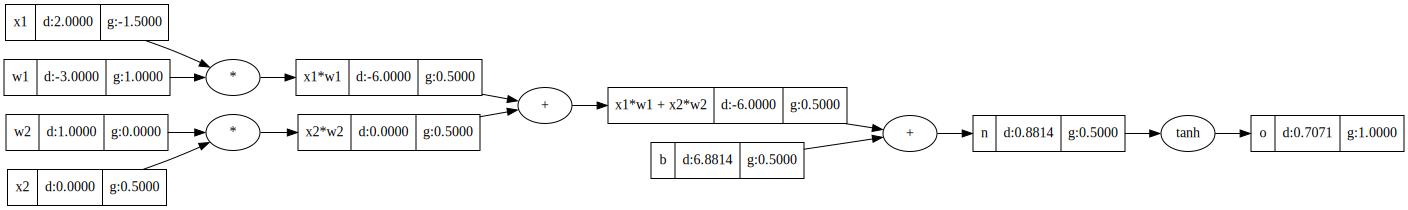

In [226]:
draw_dot(o)

Now, we will calculate the total derivative with respect of all the variables:

* $\cfrac{d}{do}o = 1$

* $\cfrac{d}{dn}o = \cfrac{d}{dn}tanh(n) = 4 \cfrac{e^{2n}}{(e^{2n + 1})^2} = 1 - tanh^2(n) = 1 - o^2$, from properties

* $\cfrac{d}{db}o = \cfrac{d}{dn}o \cdot \cfrac{d}{db}n = (1 - o^2) \cdot 1 = 1 - o^2$

* $\cfrac{d}{d(x_1w_1\_x_2w_2)}o = 1 - o^2$

* $\cfrac{d}{d(x_1w_1)}o = 1 - o^2$

* $\cfrac{d}{d(x_2w_2)}o = 1 - o^2$

* $\cfrac{d}{dx_1}o = \cfrac{d}{dn}o \cdot \cfrac{d}{d(x_1w_1\_x_2w_2)}n \cdot \cfrac{d}{d(x_1w_1)}(x_1w_1\_x_2w_2) \cdot \cfrac{d}{dx_1}(x_1w_1) = (1 - o^2) \cdot 1 \cdot w_1 = (1 - o^2) \cdot w_1$

* $\cfrac{d}{dw_1}o = \cfrac{d}{dn}o \cdot \cfrac{d}{d(x_1w_1\_x_2w_2)}n \cdot \cfrac{d}{d(x_1w_1)}(x_1w_1\_x_2w_2) \cdot \cfrac{d}{dw_1}(x_1w_1) = (1 - o^2) \cdot 1 \cdot x_1 = (1 - o^2) \cdot x_1$

* $\cfrac{d}{dx_2}o = \cfrac{d}{dn}o \cdot \cfrac{d}{d(x_1w_1\_x_2w_2)}n \cdot \cfrac{d}{d(x_2w_2)}(x_1w_1\_x_2w_2) \cdot \cfrac{d}{dx_2}(x_2w_2) = (1 - o^2) \cdot 1 \cdot w_2 = (1 - o^2) \cdot w_2$

* $\cfrac{d}{dw_2}o = \cfrac{d}{dn}o \cdot \cfrac{d}{d(x_1w_1\_x_2w_2)}n \cdot \cfrac{d}{d(x_2w_2)}(x_1w_1\_x_2w_2) \cdot \cfrac{d}{dw_2}(x_2w_2) = (1 - o^2) \cdot 1 \cdot x_2 = (1 - o^2) \cdot x_2$

In [225]:
o.grad = 1
n.grad = 1 - o.data**2
b.grad = 1 - o.data**2
x1w1_x2w2.grad = 1 - o.data**2
x1w1.grad = 1 - o.data**2
x2w2.grad = 1 - o.data**2
x1.grad = (1 - o.data**2) * w1.data
w1.grad = (1 - o.data**2) * x1.data
x2.grad = (1 - o.data**2) * w2.data
w2.grad = (1 - o.data**2) * x2.data

In [230]:
def manual_check():
    h = 1e-4

    x1 = Value(2.0, label="x1")
    x2 = Value(0.0, label="x2")
    w1 = Value(-3.0, label="w1")
    w2 = Value(1.0, label="w2")
    b = Value(6.88137, label="b")
    x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
    x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
    x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1*w1 + x2*w2"
    n = x1w1_x2w2 + b ; n.label = "n"
    o = n.tanh() ; o.label = 'o'
    o1 = o.data

    x1 = Value(2.0, label="x1")
    x2 = Value(0.0 + h, label="x2")
    w1 = Value(-3.0, label="w1")
    w2 = Value(1.0, label="w2")
    b = Value(6.88137, label="b")
    x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
    x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
    x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1*w1 + x2*w2"
    n = x1w1_x2w2 + b ; n.label = "n"
    o = n.tanh() ; o.label = 'o'
    o2 = o.data

    print((o2 - o1) / h)

manual_check()

0.4999671818117779


## Automating Backpropagation

In [268]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        `_children` (tuple): For a `Value` object tell us the `Value` objects that produce it.
        `_op` (str): The operation that from children we can produce `self`.
        `label` (str): The label of the object, for visualizing the expression.
        """

        self.data = data
        self.grad = 0.0               # Initializing to 0 because we don't want to affect the output
        self._backward = lambda: None # Initializing to empy function to handle the leaf nodes
        self._prev = set(_children)   # We are storing in a set for efficiency, O(logn) retrieving and adding complexity
        self._op = _op
        self.label = label

    def __repr__(self):
        if self.label != '':
            return f"Value=({self.data}, label={self.label})"
        return f"Value=({self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # Updating `_children` total gradients by passing through derivative
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        # Updating `_children` total gradients by applying the rule we found out before
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), _children=(self,), _op="tanh")

        def _backward():
            self.grad = (1 - out.data**2) * out.grad
        out._backward = _backward

        return out

In [269]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137, label="b")

x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1*w1 + x2*w2"
n = x1w1_x2w2 + b ; n.label = "n"

# Using as activation function the `tanh`
o = n.tanh() ; o.label = 'o'

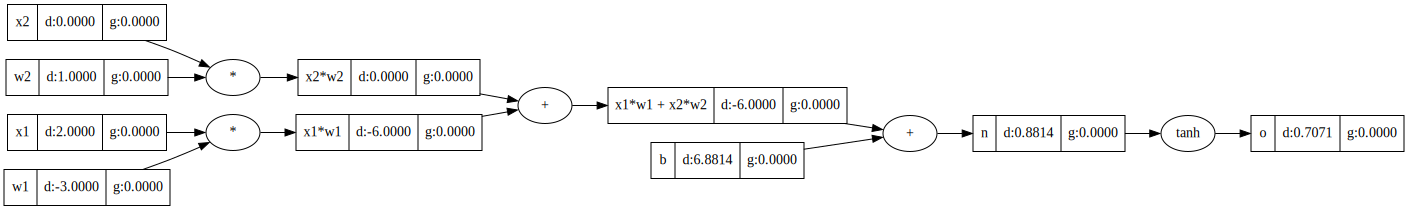

In [270]:
draw_dot(o)

In [271]:
# Setting the derivative of `o`` with respect of `o`` to 1, in order to start the process
o.grad = 1
o._backward()
n._backward()
x1w1_x2w2._backward()
x1w1._backward()
x2w2._backward()
b._backward()  # leaf node, so doesn't do anything
x1._backward() # leaf node, so doesn't do anything
w1._backward() # leaf node, so doesn't do anything
x2._backward() # leaf node, so doesn't do anything
w2._backward() # leaf node, so doesn't do anything


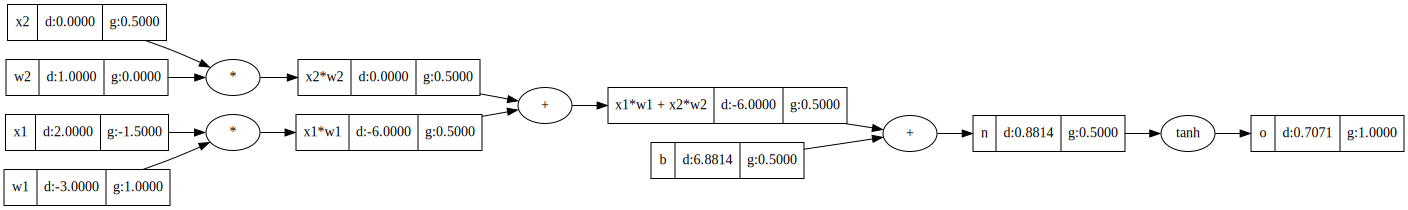

In [272]:
draw_dot(o)

## Topological Sorting

The whole purpose for creating `_backward` was to not call manualy the backward method for each node of the expression.

In order to do that we need a way to converting the graph in a form that information can only pass through one way. This is the concept of `topological sorting`.

In [273]:
def topological_sorting(root):
    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            
            for child in v._prev:
                build_topo(child)
            
            topo.append(v) # Each node is appended only if their children has being processed

    build_topo(root)
    return topo

In [274]:
topo = topological_sorting(o)

topo

[Value=(2.0, label=x1),
 Value=(-3.0, label=w1),
 Value=(-6.0, label=x1*w1),
 Value=(1.0, label=w2),
 Value=(0.0, label=x2),
 Value=(0.0, label=x2*w2),
 Value=(-6.0, label=x1*w1 + x2*w2),
 Value=(6.88137, label=b),
 Value=(0.8813700000000004, label=n),
 Value=(0.7071049876722272, label=o)]

## Performing Autograd

In [283]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137, label="b")

x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1*w1 + x2*w2"
n = x1w1_x2w2 + b ; n.label = "n"

# Using as activation function the `tanh`
o = n.tanh() ; o.label = 'o'

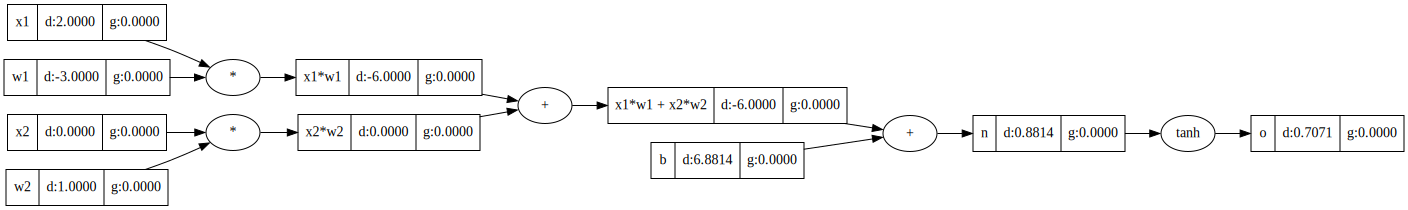

In [284]:
draw_dot(o)

In [285]:
o.grad = 1.0

In [286]:
topo = topological_sorting(o)

In [287]:
for n in reversed(topo):
    n._backward()

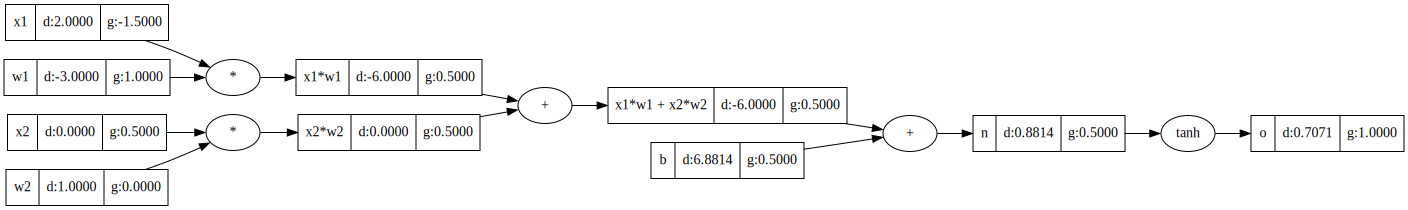

In [288]:
draw_dot(o)

## Creating the final-ish Class

In [289]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        `_children` (tuple): For a `Value` object tell us the `Value` objects that produce it.
        `_op` (str): The operation that from children we can produce `self`.
        `label` (str): The label of the object, for visualizing the expression.
        """

        self.data = data
        self.grad = 0.0               # Initializing to 0 because we don't want to affect the output
        self._backward = lambda: None # Initializing to empy function to handle the leaf nodes
        self._prev = set(_children)   # We are storing in a set for efficiency, O(logn) retrieving and adding complexity
        self._op = _op
        self.label = label


    def __repr__(self):
        if self.label != '':
            return f"Value=({self.data}, label={self.label})"
        return f"Value=({self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # Updating `_children` total gradients by passing through derivative
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out


    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        # Updating `_children` total gradients by applying the rule we found out before
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out
    

    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), _children=(self,), _op="tanh")

        def _backward():
            self.grad = (1 - out.data**2) * out.grad
        out._backward = _backward

        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for n in reversed(topo):
            n._backward()

In [290]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137, label="b")

x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1*w1 + x2*w2"
n = x1w1_x2w2 + b ; n.label = "n"

# Using as activation function the `tanh`
o = n.tanh() ; o.label = 'o'

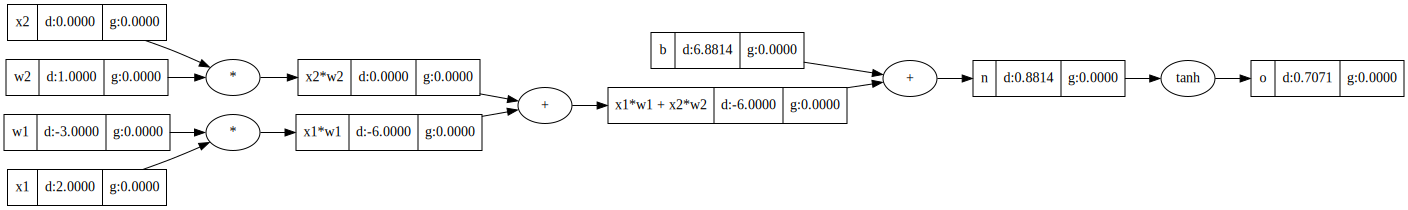

In [291]:
draw_dot(o)

In [292]:
o.backward()

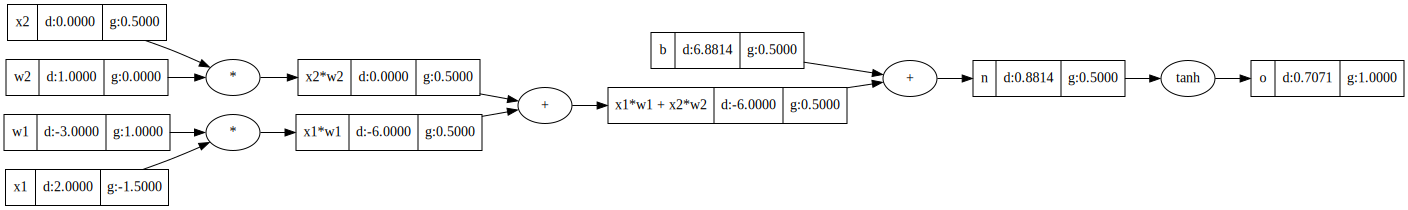

In [293]:
draw_dot(o)

## The Bag in the Code

Will get an unexpected behaviour each time we use a variable more than once (crossing arrows).

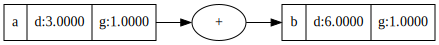

In [296]:
a = Value(3.0, label="a")
b = a + a ; b.label = "b"

b.backward()

draw_dot(b)

the total derivative with respect of `a` should be $2$ not $1$. 

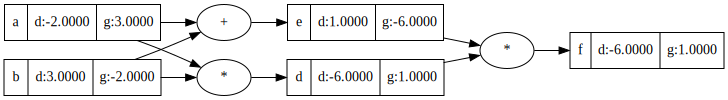

In [297]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b ; d.label = "d"
e = a + b ; e.label = "e"
f = d * e ; f.label = "f"

f.backward()

draw_dot(f)

where the correct derivatives are:  $\cfrac{d}{da}f = -3$ and $\cfrac{d}{db}f = -8$.

## Solving the Bag

We are adding the grads to avoid this problem. Remember the results in the case of one use of each variable are still correct, because we have initialized `.grad` at zero.

In [298]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        `_children` (tuple): For a `Value` object tell us the `Value` objects that produce it.
        `_op` (str): The operation that from children we can produce `self`.
        `label` (str): The label of the object, for visualizing the expression.
        """

        self.data = data
        self.grad = 0.0               # Initializing to 0 because we don't want to affect the output
        self._backward = lambda: None # Initializing to empy function to handle the leaf nodes
        self._prev = set(_children)   # We are storing in a set for efficiency, O(logn) retrieving and adding complexity
        self._op = _op
        self.label = label


    def __repr__(self):
        if self.label != '':
            return f"Value=({self.data}, label={self.label})"
        return f"Value=({self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # Updating `_children` total gradients by passing through derivative
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out


    def __mul__(self, other):
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        # Updating `_children` total gradients by applying the rule we found out before
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out


    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), _children=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward

        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for n in reversed(topo):
            n._backward()

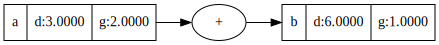

In [299]:
a = Value(3.0, label="a")
b = a + a ; b.label = "b"

b.backward()

draw_dot(b)

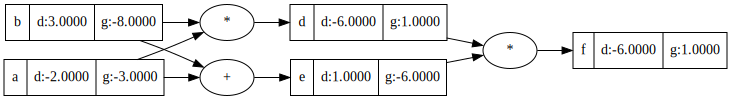

In [300]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b ; d.label = "d"
e = a + b ; e.label = "e"
f = d * e ; f.label = "f"

f.backward()

draw_dot(f)

## Adding Functionality to the Class

In [330]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        """
        `_children` (tuple): For a `Value` object tell us the `Value` objects that produce it.
        `_op` (str): The operation that from children we can produce `self`.
        `label` (str): The label of the object, for visualizing the expression.
        """

        self.data = data
        self.grad = 0.0               # Initializing to 0 because we don't want to affect the output
        self._backward = lambda: None # Initializing to empy function to handle the leaf nodes
        self._prev = set(_children)   # We are storing in a set for efficiency, O(logn) retrieving and adding complexity
        self._op = _op
        self.label = label


    def __repr__(self):
        if self.label != '':
            return f"Value=({self.data}, label={self.label})"
        return f"Value=({self.data})"
    

    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other # handling the case where we want Value + int

        out = Value(self.data + other.data, _children=(self, other), _op='+')

        # Updating `_children` total gradients by passing through derivative
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    

    def __radd__(self, other):
        return self + other # handling the case: int + Value
    

    def __sub__(self, other): # Value - other
        return self + (-other)


    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other # handling the case where we want Value * int
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        # Updating `_children` total gradients by applying the rule we found out before
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __rmul__(self, other):
        return self * other # handling the case: int * Value
    

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float types"

        out = Value(self.data**other, _children=(self,), _op=f"**{other}")

        def backward():
            self.grad += other*(self.data**(other - 1)) * out.grad

        out._backward = backward

        return out
    

    def __truediv__(self, other): # for Value / Value
        return self * (other ** -1)
    

    def exp(self):
        out = Value(math.exp(self.data), _children=(self, ), _op="exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out


    def tanh(self):
        out = Value((math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1), _children=(self,), _op="tanh")

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward

        return out
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for n in reversed(topo):
            n._backward()

Splitting `tanh` into its compenents.

In [335]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
b = Value(6.88137, label="b")

x1w1 = x1 * w1 ; x1w1.label = "x1*w1"
x2w2 = x2 * w2 ; x2w2.label = "x2*w2"
x1w1_x2w2 = x1w1 + x2w2 ; x1w1_x2w2.label = "x1*w1 + x2*w2"
n = x1w1_x2w2 + b ; n.label = "n"

# Using as activation function the `tanh`
e = (2*n).exp() ; e.label = "e"
o = (e - 1) / (e + 1)

o.label = 'o'

In [336]:
o.backward()

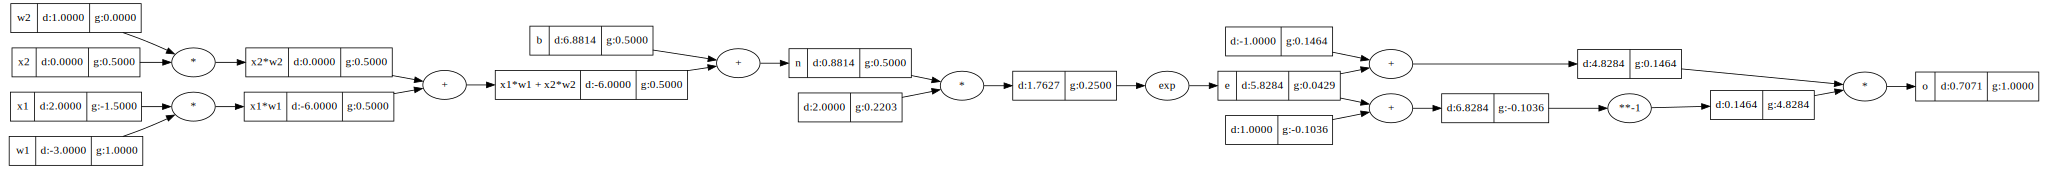

In [337]:
draw_dot(o)

## Comparison with Pytorch

In [338]:
import torch

`torch.tensor([x: float])` is converted into a `torch.float32` object, but Python stored floating point number as `torch.float64` (torch.double).

Also, by default because `torch.tensor([x: float])` is a leaf node, Pytorch don't expect gradient calculation, so we need to specify this.

In [342]:
x1 = torch.tensor([2.0]).double()    ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double()    ; x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()   ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double()    ; w2.requires_grad = True
b = torch.tensor([6.88137]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.item()

0.7071050214706146

In [343]:
o.backward()

In [344]:
print("x1 grad", x1.grad.item())
print("w1 grad", w1.grad.item())
print("x2 grad", x2.grad.item())
print("w2 grad", w2.grad.item())

x1 grad -1.500007465833125
w1 grad 1.0000049772220834
x2 grad 0.5000024886110417
w2 grad 0.0
